In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import skimage.transform
from sklearn.model_selection import train_test_split
from network import neural_network
import cv2

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def read_pictures(directory='train/'):
    with open('files_list.txt') as f:
        files_list = f.readlines()
    files_list = [(directory+i.strip()) for i in files_list]
    return files_list

In [3]:
input_shape = (256, 256, 3)
# files_list = read_pictures('preprocessed_images/')
files_list = read_pictures()

In [4]:
def preprocess_img(img):
    return skimage.transform.resize(img, input_shape)

In [5]:
def get_dataset(preprocess = True, files_num=1000, random=False):
    X = np.empty((files_num, *input_shape), dtype=np.float32)
    y = np.empty((files_num, 2), dtype=np.uint8)
    
    if random:
        files_to_read = np.random.choice(files_list, files_num)
    else:
        files_to_read = files_list[:files_num]
        
    if preprocess:
        operation = lambda x: preprocess_img(cv2.imread(x))[:,:,::-1]
    else:
        operation = lambda x: cv2.imread(x)[:,:,::-1]
        
    for num, i in enumerate(tqdm.tqdm(files_to_read)):
        X[num] = operation(i)
#         if preprocess:
#             X[num] = preprocess_img(cv2.imread(i))[:,:,::-1]
#         else:
#             X[num] = cv2.imread(i)[:,:,::-1]
            
        if 'cat' in i:
            y[num] = [1, 0]
        else:
            y[num] = [0, 1]
    return X, y

In [6]:
def save_preprocessed_images(images):
    for i, name in tqdm.tqdm(zip(images, files_list)):
        plt.imsave(f'preprocessed_images/{name.split("/")[-1]}', i)

In [7]:
X, y = get_dataset(preprocess=True, files_num=10000, random=True)
# X = X/np.max(X)

  0%|                                        | 0/10000 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
100%|████████████████████████████| 10000/10000 [04:53<00:00, 34.06it/s]


In [8]:
# save_preprocessed_images(X)

25000it [01:51, 223.98it/s]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Free memory
X=None
y=None

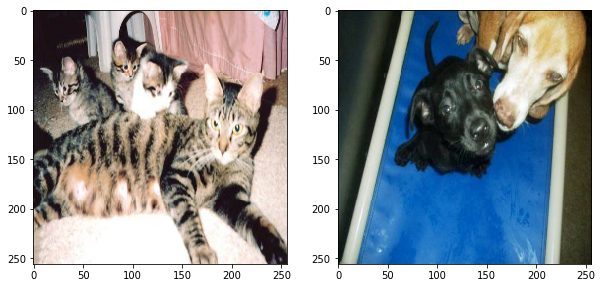

In [9]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(X_train[1]);
plt.subplot(122)
plt.imshow(X_train[0])
plt.show()

In [91]:
class cnn_network(neural_network):       
    def _inference(self):
        inp = self.input
        with tf.name_scope('classificator'):
            with tf.name_scope('convolution'):
                layer = tf.layers.conv2d(inp, 64, 3, activation=tf.nn.relu)
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
        
                layer = tf.layers.conv2d(layer, 64, 3, activation=tf.nn.relu)
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                layer = tf.nn.dropout(layer, self.dropout_prob)
                
                layer = tf.layers.conv2d(layer, 64, 3, activation=tf.nn.relu)
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                
                layer = tf.layers.conv2d(layer, 64, 3, activation=tf.nn.relu, padding='same')
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                
                layer = tf.layers.conv2d(layer, 64, 3, activation=tf.nn.relu, padding='same')
                layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                layer = tf.nn.dropout(layer, self.dropout_prob)
                
#                 layer = tf.layers.conv2d(layer, 16, , activation=tf.nn.relu)
#                 layer = tf.layers.max_pooling2d(layer, pool_size=3, strides=2)
                
                layer = tf.layers.flatten(layer)

            with tf.name_scope('dense'):
                layer = tf.layers.dense(layer, 1024, activation=tf.nn.relu)
                layer = tf.nn.dropout(layer, self.dropout_prob)
                layer = tf.layers.dense(layer, 512, activation=tf.nn.relu)
                layer = tf.layers.batch_normalization(layer)
                layer = tf.layers.dense(layer, 256, activation=tf.nn.relu)
                layer = tf.layers.dense(layer, 128, activation=tf.nn.relu)
#                 layer = tf.layers.batch_normalization(layer)
                layer = tf.layers.dense(layer, 2, activation=tf.nn.softmax)

        return layer

In [93]:
tf.reset_default_graph()
network = cnn_network(input_shape, X_train, y_train, X_test, y_test)
network.training(batch_size=128, epochs=15, iter_before_validation=1)





  0%|                                           | 0/15 [00:00<?, ?it/s]

Test accuracy: 61% 	Training loss: 0.6913781960805258 	 Training accuracy: 60%






  7%|██▎                                | 1/15 [00:17<03:59, 17.08s/it]

Test accuracy: 64% 	Training loss: 0.6518764043295825 	 Training accuracy: 62%






 13%|████▋                              | 2/15 [00:33<03:40, 16.97s/it]

Test accuracy: 63% 	Training loss: 0.624236958998221 	 Training accuracy: 65%






 20%|███████                            | 3/15 [00:50<03:22, 16.87s/it]

Test accuracy: 72% 	Training loss: 0.603613797161314 	 Training accuracy: 67%






 27%|█████████▎                         | 4/15 [01:07<03:05, 16.82s/it]

Test accuracy: 71% 	Training loss: 0.5872059718326286 	 Training accuracy: 75%






 33%|███████████▋                       | 5/15 [01:23<02:47, 16.79s/it]

Test accuracy: 73% 	Training loss: 0.5657359229193791 	 Training accuracy: 71%






 40%|██████████████                     | 6/15 [01:40<02:30, 16.77s/it]

Test accuracy: 73% 	Training loss: 0.5699094765716128 	 Training accuracy: 75%






 47%|████████████████▎                  | 7/15 [01:57<02:13, 16.75s/it]

Test accuracy: 78% 	Training loss: 0.529785656818637 	 Training accuracy: 74%






 53%|██████████████████▋                | 8/15 [02:13<01:57, 16.71s/it]

Test accuracy: 78% 	Training loss: 0.5339115571092675 	 Training accuracy: 74%






 60%|█████████████████████              | 9/15 [02:30<01:40, 16.69s/it]

Test accuracy: 79% 	Training loss: 0.5102910465664334 	 Training accuracy: 75%






 67%|██████████████████████▋           | 10/15 [02:46<01:23, 16.67s/it]

Test accuracy: 80% 	Training loss: 0.508589211989332 	 Training accuracy: 78%






 73%|████████████████████████▉         | 11/15 [03:03<01:06, 16.65s/it]

Test accuracy: 78% 	Training loss: 0.49583592734954984 	 Training accuracy: 77%






 80%|███████████████████████████▏      | 12/15 [03:19<00:49, 16.64s/it]

Test accuracy: 79% 	Training loss: 0.48653804538426576 	 Training accuracy: 77%






 87%|█████████████████████████████▍    | 13/15 [03:36<00:33, 16.63s/it]

Test accuracy: 82% 	Training loss: 0.48593886914076617 	 Training accuracy: 82%






 93%|███████████████████████████████▋  | 14/15 [03:52<00:16, 16.62s/it]

Test accuracy: 82% 	Training loss: 0.46894743376308023 	 Training accuracy: 83%






100%|██████████████████████████████████| 15/15 [04:09<00:00, 16.62s/it]





In [47]:
assert len([op.name for op in tf.get_default_graph().get_operations() if 'output' in op.name or 'features' in op.name]) == 2
assert len([op.name for op in tf.get_default_graph().get_operations() if 'cnn_' in op.name]) == 0

In [48]:
network.save_model('saved_model/classifier_small.ckpt')